In [1]:
from IPython.core.display import HTML
with open('../style.css', 'r') as file:
    css = file.read()
HTML(css)

# The Knight's Tour

This notebook computes a solution to the [knight's tour](https://en.wikipedia.org/wiki/Knight%27s_tour) using the constraint solver `Z3`.  

In [2]:
import z3

Given an integer from the set $\{1, \cdots, 64\}$, the function `row(i)` computes the name of the variable that specifies the *row* of the knight before its $i^{\textrm{th}}$ move.

In [3]:
def row(i):
    return f'R{i}'

Given an integer from the set $\{1, \cdots, 64\}$, the function `row(i)` computes the name of the variable that specifies the *column* of the knight before its $i^{\textrm{th}}$ move.

In [4]:
def col(i):
    return f'C{i}'

The function `all_variables` computes the names of all variables.

In [5]:
def all_variables():
    Variables = set()
    for i in range(1, 65):
        Variables.add(row(i))
        Variables.add(col(i))
    return Variables

In [6]:
all_variables()

{'C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C2',
 'C20',
 'C21',
 'C22',
 'C23',
 'C24',
 'C25',
 'C26',
 'C27',
 'C28',
 'C29',
 'C3',
 'C30',
 'C31',
 'C32',
 'C33',
 'C34',
 'C35',
 'C36',
 'C37',
 'C38',
 'C39',
 'C4',
 'C40',
 'C41',
 'C42',
 'C43',
 'C44',
 'C45',
 'C46',
 'C47',
 'C48',
 'C49',
 'C5',
 'C50',
 'C51',
 'C52',
 'C53',
 'C54',
 'C55',
 'C56',
 'C57',
 'C58',
 'C59',
 'C6',
 'C60',
 'C61',
 'C62',
 'C63',
 'C64',
 'C7',
 'C8',
 'C9',
 'R1',
 'R10',
 'R11',
 'R12',
 'R13',
 'R14',
 'R15',
 'R16',
 'R17',
 'R18',
 'R19',
 'R2',
 'R20',
 'R21',
 'R22',
 'R23',
 'R24',
 'R25',
 'R26',
 'R27',
 'R28',
 'R29',
 'R3',
 'R30',
 'R31',
 'R32',
 'R33',
 'R34',
 'R35',
 'R36',
 'R37',
 'R38',
 'R39',
 'R4',
 'R40',
 'R41',
 'R42',
 'R43',
 'R44',
 'R45',
 'R46',
 'R47',
 'R48',
 'R49',
 'R5',
 'R50',
 'R51',
 'R52',
 'R53',
 'R54',
 'R55',
 'R56',
 'R57',
 'R58',
 'R59',
 'R6',
 'R60',
 'R61',
 'R62',
 'R63',
 'R64',
 'R7',
 'R8',
 

The function `is_knight_move(i)` returns a formula that specifies that the $i^{\textrm{th}}$ move is a legal move for a knight.

In [7]:
def is_knight_move(i):
    r  = row(i)
    c  = col(i)
    rX = row(i+1)
    cX = col(i+1)
    Formulas = set()
    for delta_r, delta_c in [(1, 2), (2, 1)]:
        Formulas.add(f'z3.And({rX} == {r} + {delta_r}, {cX} == {c} + {delta_c})')
        Formulas.add(f'z3.And({rX} == {r} + {delta_r}, {cX} + {delta_c} == {c})')
        Formulas.add(f'z3.And({rX} + {delta_r} == {r}, {cX} == {c} + {delta_c})')
        Formulas.add(f'z3.And({rX} + {delta_r} == {r}, {cX} + {delta_c} == {c})') 
    return 'z3.Or(' + ', '.join(Formulas) + ')'

In [8]:
is_knight_move(1)

'z3.Or(z3.And(R2 == R1 + 1, C2 + 2 == C1), z3.And(R2 == R1 + 2, C2 == C1 + 1), z3.And(R2 == R1 + 1, C2 == C1 + 2), z3.And(R2 + 1 == R1, C2 == C1 + 2), z3.And(R2 == R1 + 2, C2 + 1 == C1), z3.And(R2 + 2 == R1, C2 == C1 + 1), z3.And(R2 + 1 == R1, C2 + 2 == C1), z3.And(R2 + 2 == R1, C2 + 1 == C1))'

The function `all_different` computes a set of formulas specifiying that
$$ \langle \textrm{R}i, \textrm{C}i \rangle \not= \langle \textrm{R}j, \textrm{C}j \rangle $$
provided that $i \not= j$.

In [9]:
def all_different():
    Result = set()
    for i in range(1, 64):
        for j in range (i+1, 65):
            Result.add(f'z3.Or({row(i)} != {row(j)}, {col(i)} != {col(j)})')
    return Result

In [10]:
def all_constraints():
    Constraints = all_different()
    Constraints.add(f'{row(1)} == 0')
    Constraints.add(f'{col(1)} == 0')
    Constraints.add(f'{row(64)} == 1')
    Constraints.add(f'{col(64)} == 2')
    for i in range(1, 64):
        Constraints.add(is_knight_move(i))
    for i in range(1, 65):
        Constraints.add(f'{row(i)} >= 0')
        Constraints.add(f'{col(i)} >= 0')
    return Constraints

In [11]:
len(all_constraints())

2211

The function `solve(Constraints, Variables)` receives two arguments:
- `Constraints` is a set of formulas representing a constraint satisfaction problem.
- `Variables`   is the set of variables that occur in this formulas.

   It is assumed that all Variables can be presented by bit-vector of length 4.

The function computes a solution to the given problem and returns this solution.

In [12]:
def solve(Constraints, Variables):
    Environment = {}
    exec('import z3', Environment)
    for v in Variables:
        exec(f'{v} = z3.BitVec(f"{v}", 4)', Environment)
    s = z3.Solver()
    for c in Constraints:
        s.add(eval(c, Environment))
    s.check()
    m = s.model()
    S = { v: m[eval(v, Environment)] for v in Variables }
    return S

The following cell takes about 5 minutes and 5 seconds on my `3,4 GHz Quad-Core Intel Core i5` *iMac* from 2017.

In [13]:
%%time
Solution = solve(all_constraints(), all_variables())
Solution

CPU times: user 4min 48s, sys: 862 ms, total: 4min 49s
Wall time: 4min 52s


{'C2': 1,
 'R33': 3,
 'R27': 1,
 'C58': 0,
 'R3': 4,
 'C18': 6,
 'C52': 6,
 'R48': 0,
 'R37': 0,
 'C20': 5,
 'R13': 7,
 'C47': 4,
 'R64': 1,
 'C49': 7,
 'C7': 5,
 'R25': 2,
 'C38': 5,
 'C26': 7,
 'C64': 2,
 'R44': 3,
 'C11': 2,
 'R51': 5,
 'C55': 4,
 'C23': 6,
 'R58': 7,
 'C51': 7,
 'R24': 4,
 'R4': 6,
 'R35': 3,
 'R26': 0,
 'C48': 5,
 'C10': 4,
 'R63': 3,
 'C33': 1,
 'R40': 3,
 'C34': 3,
 'R15': 4,
 'R8': 6,
 'R55': 6,
 'R28': 2,
 'R10': 3,
 'C29': 6,
 'R38': 2,
 'R50': 3,
 'R9': 4,
 'C15': 4,
 'C31': 2,
 'R34': 2,
 'R12': 5,
 'C8': 7,
 'R6': 5,
 'C9': 6,
 'R23': 6,
 'C53': 5,
 'R17': 7,
 'C22': 4,
 'R46': 0,
 'R52': 7,
 'C1': 0,
 'R2': 2,
 'C21': 3,
 'R45': 1,
 'R53': 5,
 'R36': 1,
 'C13': 1,
 'R62': 5,
 'C42': 1,
 'C32': 0,
 'R59': 6,
 'R41': 2,
 'R21': 5,
 'R47': 2,
 'R31': 0,
 'C41': 0,
 'C43': 2,
 'C36': 6,
 'R30': 1,
 'C56': 2,
 'C16': 5,
 'R57': 5,
 'R7': 7,
 'C12': 0,
 'R54': 4,
 'R60': 4,
 'R22': 7,
 'C14': 3,
 'R5': 7,
 'C6': 4,
 'R20': 4,
 'C46': 3,
 'C44': 0,
 'C19': 7,
 '

The function `create_board(Solution)` returns a matrix `Board` of size $8\times 8$.
The following holds:
$$ \texttt{Board}[\texttt{R}i][\texttt{C}i] = i $$
Therefore, if `Board[r][c] == i`, then at the beginning of the $i^{\textrm{th}}$ move the knight is located in row `r` and column `c`. 

In [14]:
def create_board(Solution):
    Board = [[0 for _ in range(8)] for _ in range(8)]
    for i in range(1, 65):
        r = Solution[row(i)].as_long()
        c = Solution[col(i)].as_long()
        Board[r][c] = i
    return Board

In [15]:
create_board(Solution)

[[1, 42, 31, 46, 37, 48, 29, 26],
 [32, 45, 64, 39, 30, 27, 36, 49],
 [41, 2, 43, 34, 47, 38, 25, 28],
 [44, 33, 40, 63, 10, 35, 50, 19],
 [3, 60, 11, 54, 15, 20, 9, 24],
 [12, 57, 62, 21, 6, 53, 18, 51],
 [61, 4, 59, 14, 55, 16, 23, 8],
 [58, 13, 56, 5, 22, 7, 52, 17]]

The function `print_board` prints the given `Board`.

In [16]:
def print_board(Board):
    n = len(Board)
    # Determine the width of the widest element in the matrix
    width = max([ len(str(element)) for row in Board
                                    for element in row
                ])
    # Create the top and bottom of the matrix
    top_line = '╔'
    for i in range(n - 1):
        top_line += '=' * (width + 2) + '╦'
    top_line += '=' * (width + 2) + '╗'
    mid_line = '╠'
    for i in range(n - 1):
        mid_line += '=' * (width + 2) + '╬'
    mid_line += '=' * (width + 2) + '╣'    
    bot_line = '╚'
    for i in range(n - 1):
        bot_line += '=' * (width + 2) + '╩'
    bot_line += '=' * (width + 2) + '╝'
    # Print the top of the matrix
    print(top_line)
    # Iterate through the rows and columns of the matrix, and print
    # each element with proper padding
    for i, row in enumerate(Board):
        line = '\u2551'
        for element in row:
            line += f' {element:>{width}} ║'
        print(line)
        # Print a horizontal line
        if i < len(Board) - 1:
            print(mid_line)
    # Print the bottom of the matrix
    print(bot_line)

In [17]:
print_board(create_board(Solution))

╔====╦====╦====╦====╦====╦====╦====╦====╗
║  1 ║ 42 ║ 31 ║ 46 ║ 37 ║ 48 ║ 29 ║ 26 ║
╠====╬====╬====╬====╬====╬====╬====╬====╣
║ 32 ║ 45 ║ 64 ║ 39 ║ 30 ║ 27 ║ 36 ║ 49 ║
╠====╬====╬====╬====╬====╬====╬====╬====╣
║ 41 ║  2 ║ 43 ║ 34 ║ 47 ║ 38 ║ 25 ║ 28 ║
╠====╬====╬====╬====╬====╬====╬====╬====╣
║ 44 ║ 33 ║ 40 ║ 63 ║ 10 ║ 35 ║ 50 ║ 19 ║
╠====╬====╬====╬====╬====╬====╬====╬====╣
║  3 ║ 60 ║ 11 ║ 54 ║ 15 ║ 20 ║  9 ║ 24 ║
╠====╬====╬====╬====╬====╬====╬====╬====╣
║ 12 ║ 57 ║ 62 ║ 21 ║  6 ║ 53 ║ 18 ║ 51 ║
╠====╬====╬====╬====╬====╬====╬====╬====╣
║ 61 ║  4 ║ 59 ║ 14 ║ 55 ║ 16 ║ 23 ║  8 ║
╠====╬====╬====╬====╬====╬====╬====╬====╣
║ 58 ║ 13 ║ 56 ║  5 ║ 22 ║  7 ║ 52 ║ 17 ║
╚====╩====╩====╩====╩====╩====╩====╩====╝


In [18]:
import chess

In [52]:
def to_algebraic(row, col):
    Columns = { 0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h' }
    return Columns[col] + str(row+1)

In [61]:
def show_solution(Solution):
    Solution = create_board(Solution)
    board  = chess.Board(None)  # create empty chess board
    knight = chess.Piece(chess.KNIGHT, True )
    pawn   = chess.Piece(chess.PAWN  , False)
    board.set_piece_at(0, knight)
    for row in range(0, 8):
        for col in range(0, 8):
            field_number = row * 8 + col
            if field_number != 0:
                board.set_piece_at(field_number, pawn)
    display(board)
    Positions = {}
    for row in range(0, 8):
        for col in range(0, 8):
            k = Solution[row][col]
            Positions[k] = to_algebraic(row, col)
    move = chess.Move.from_uci('a1c2')
    source = Positions[1]
    for i in range(2, 65):
        destination = Positions[i]
        move = chess.Move.from_uci(source + destination)
        board.push(move)
        display(board)
        source = destination

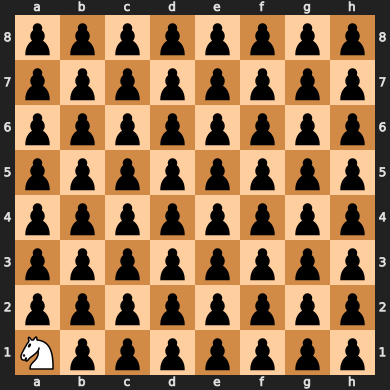

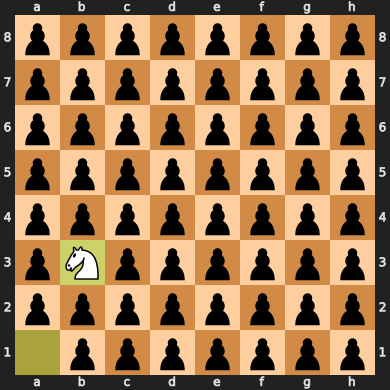

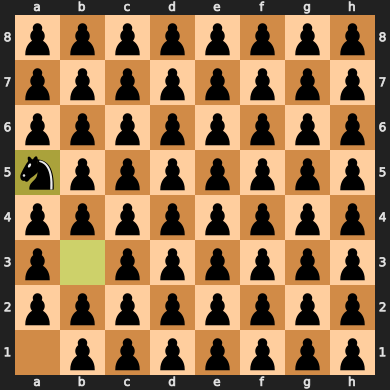

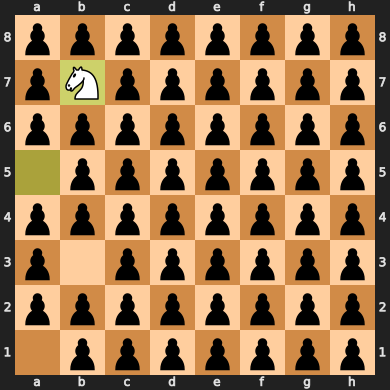

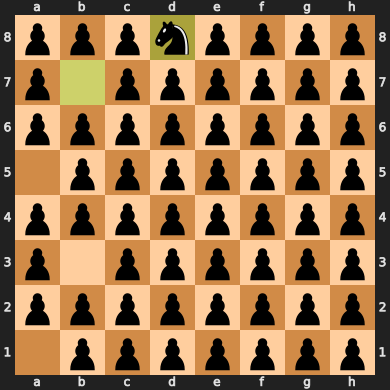

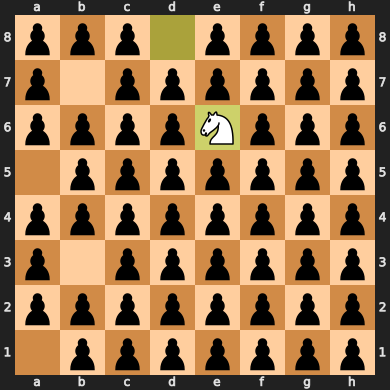

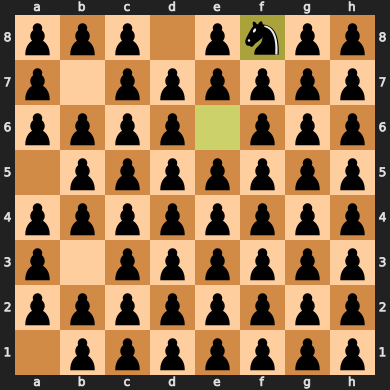

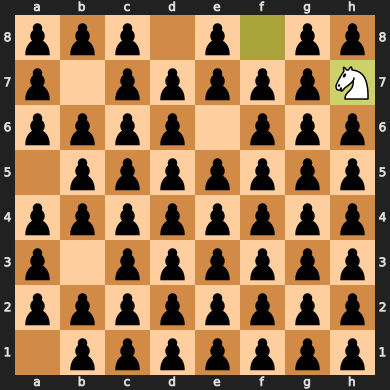

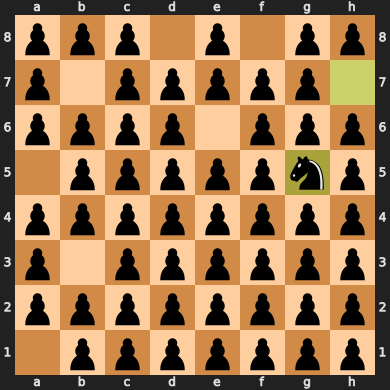

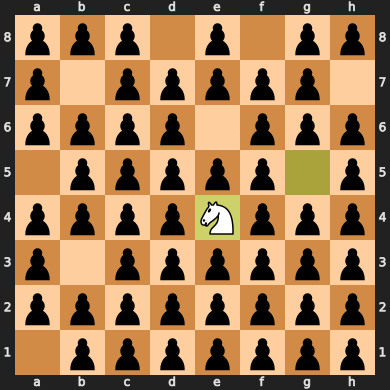

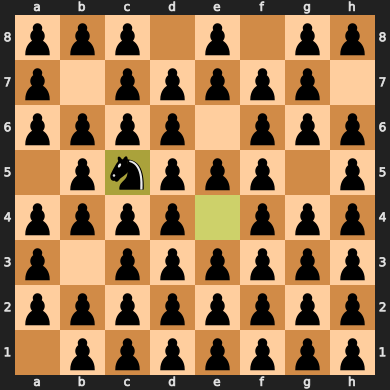

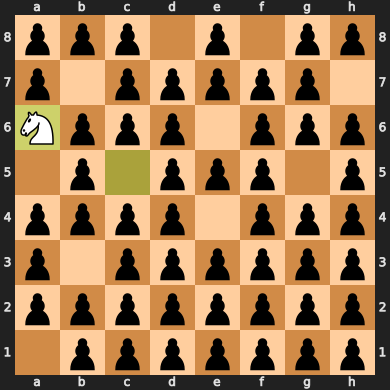

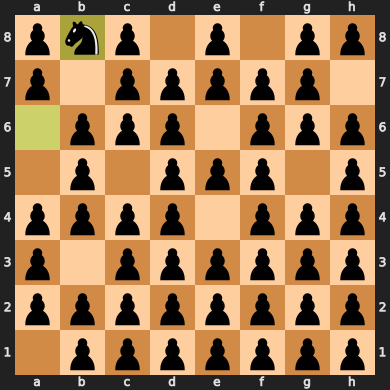

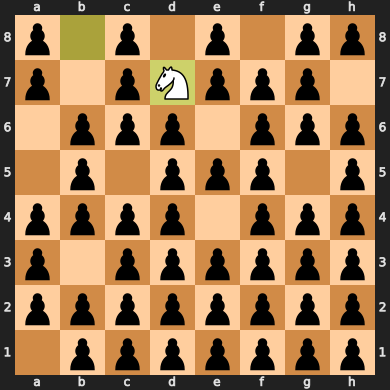

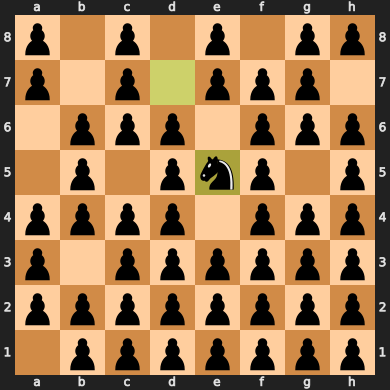

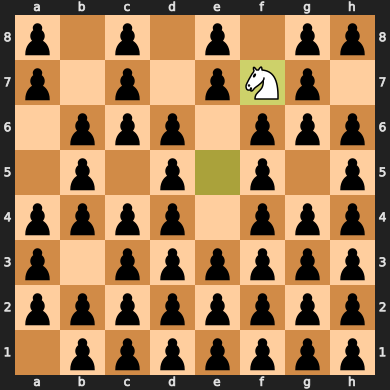

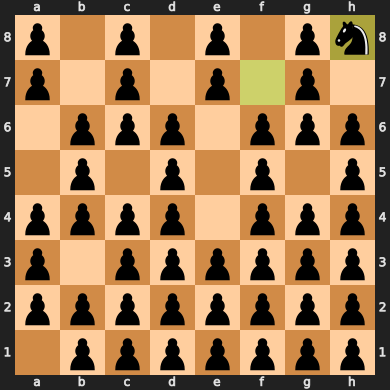

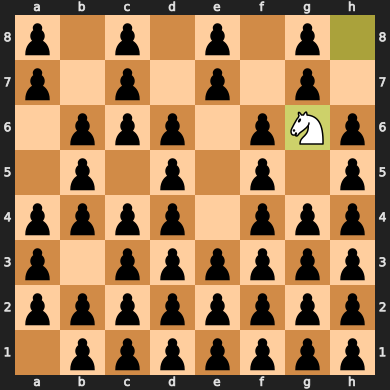

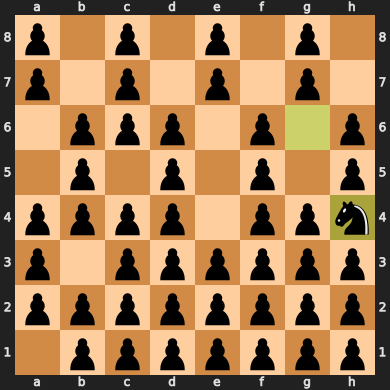

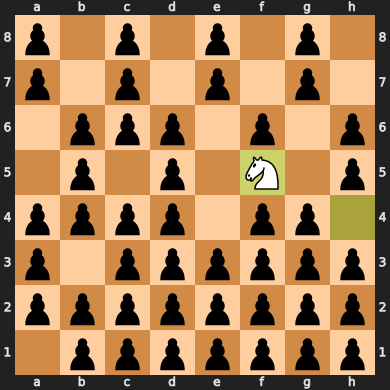

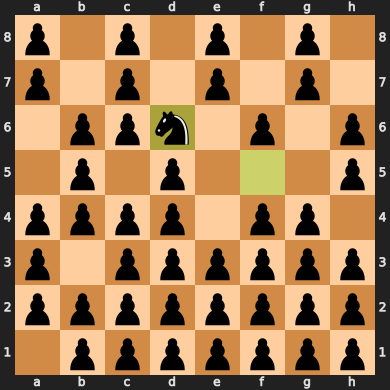

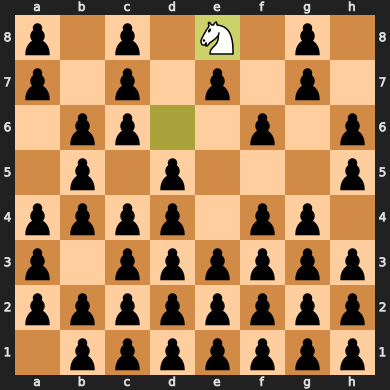

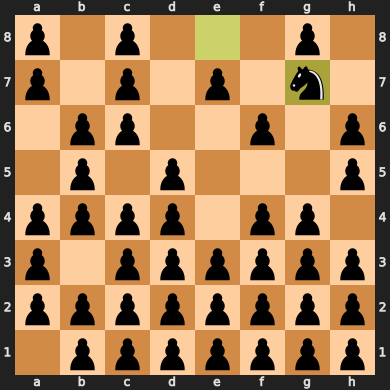

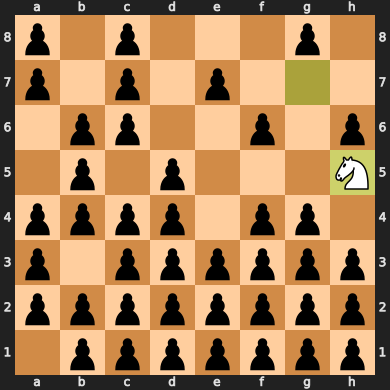

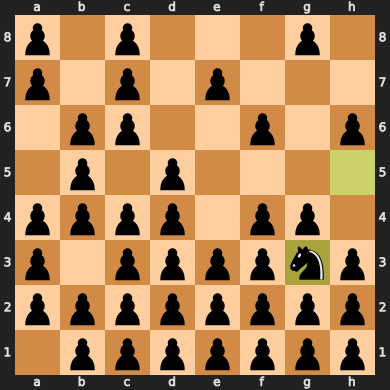

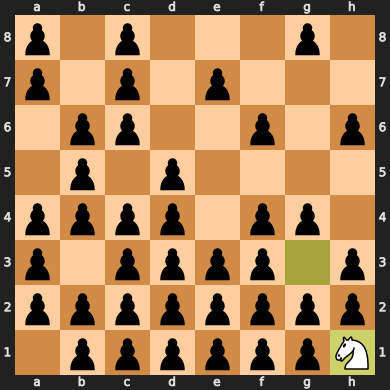

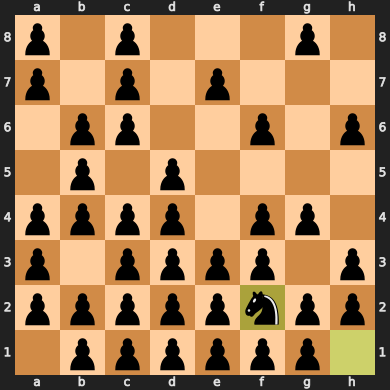

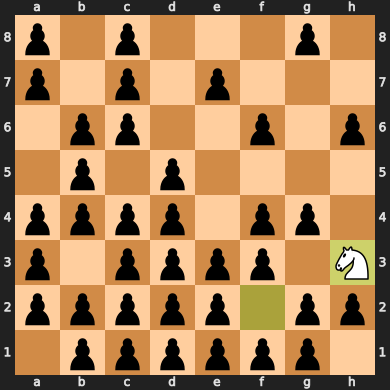

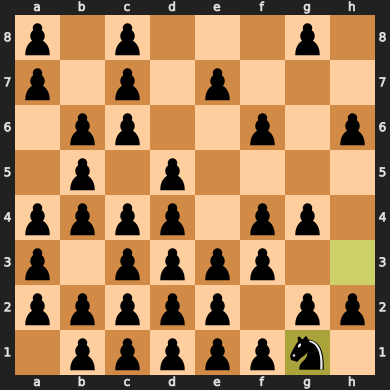

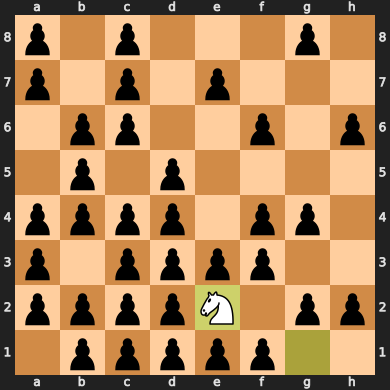

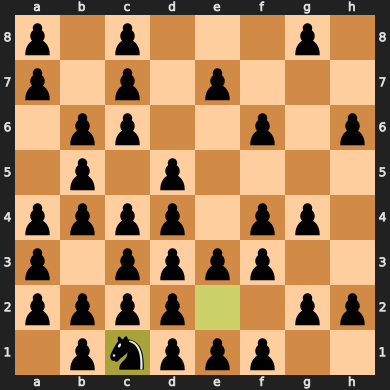

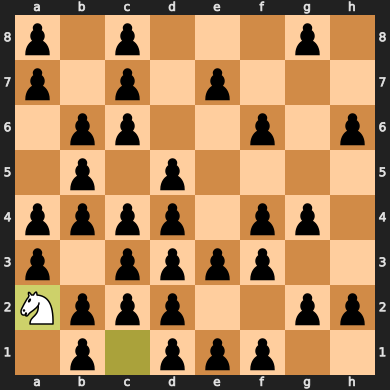

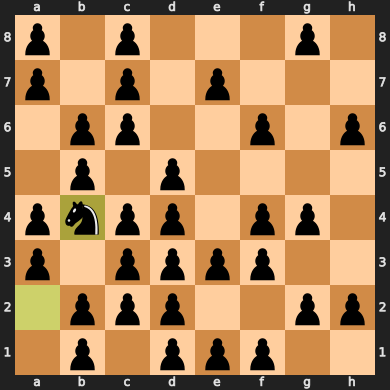

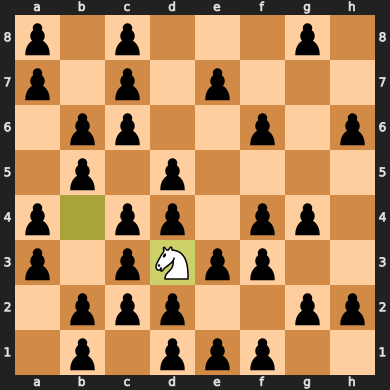

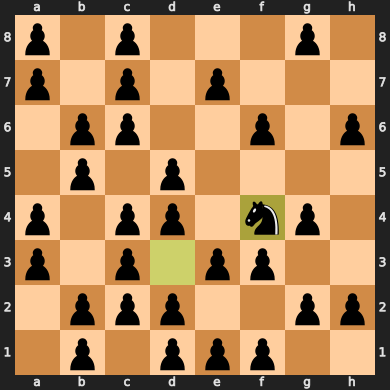

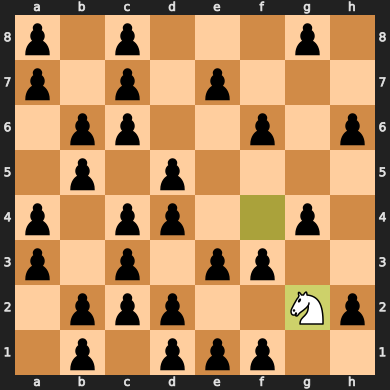

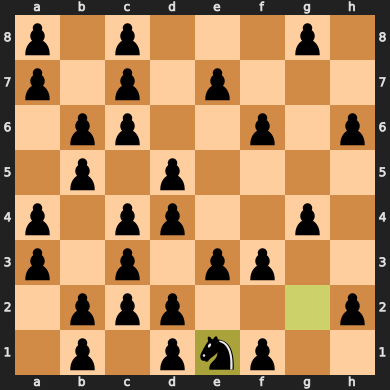

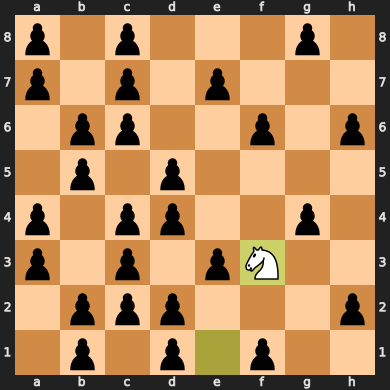

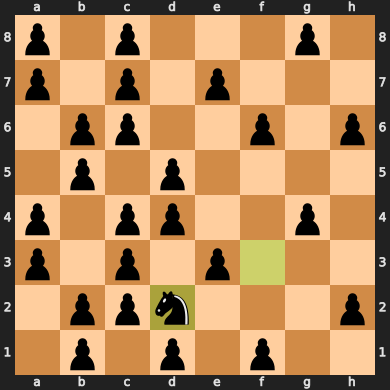

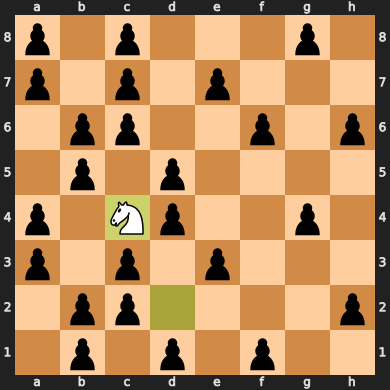

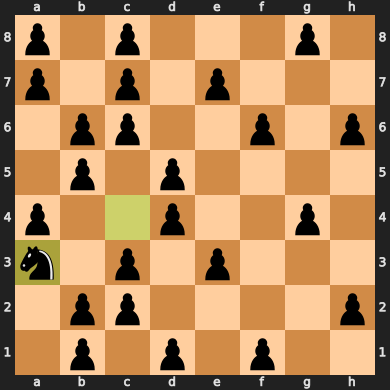

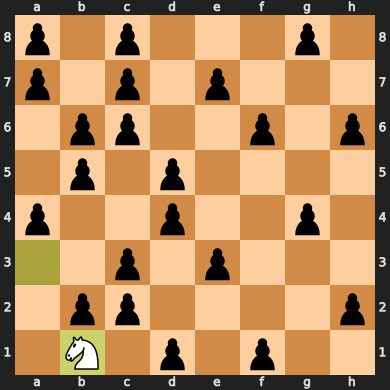

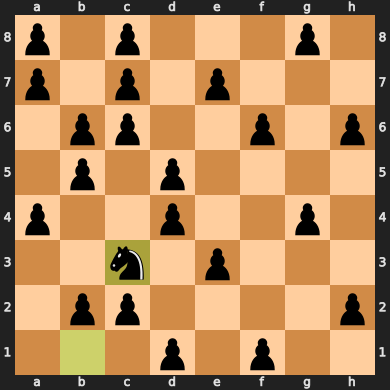

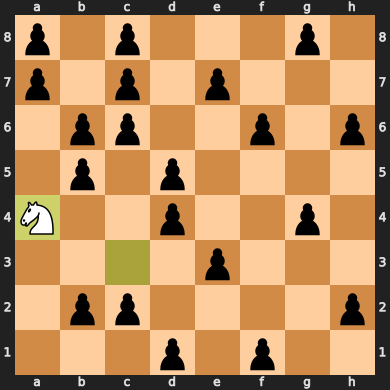

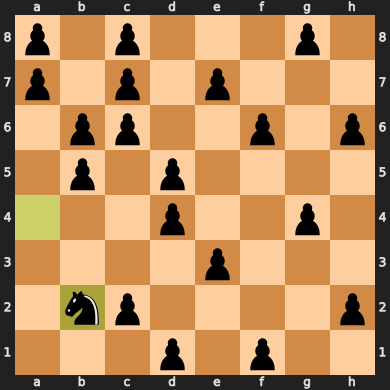

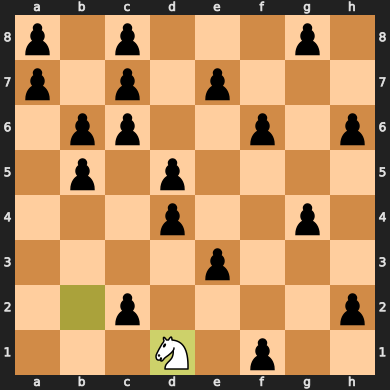

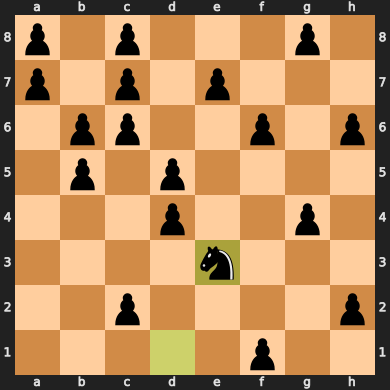

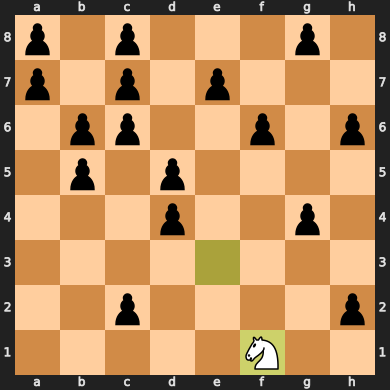

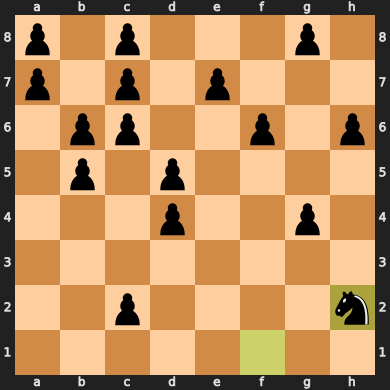

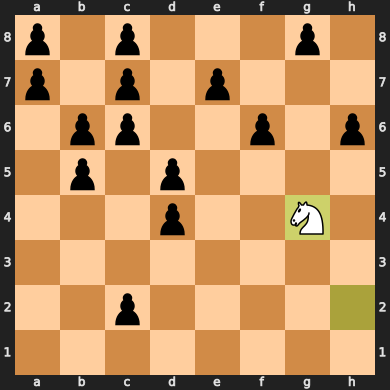

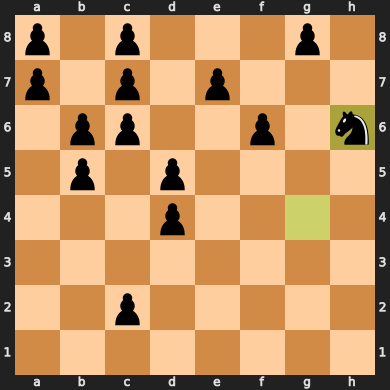

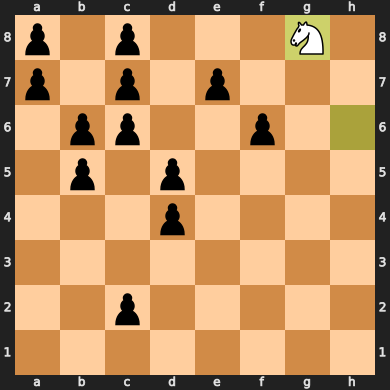

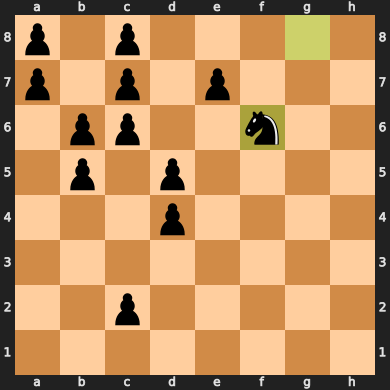

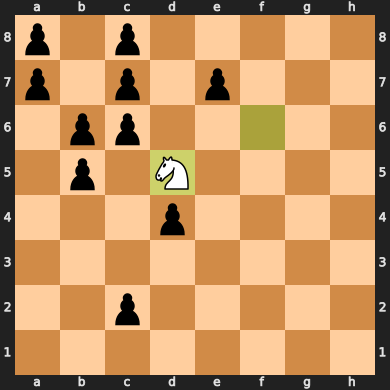

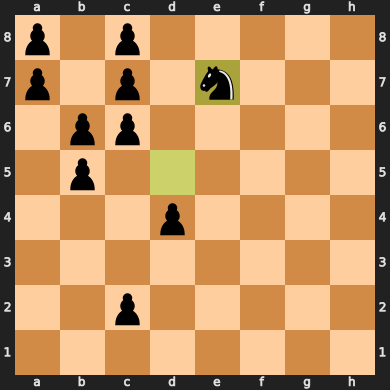

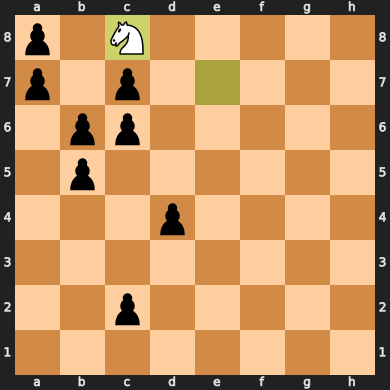

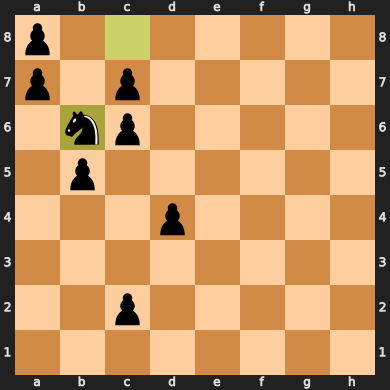

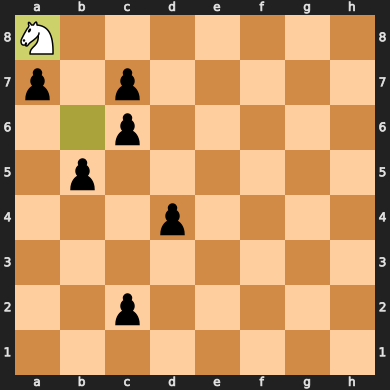

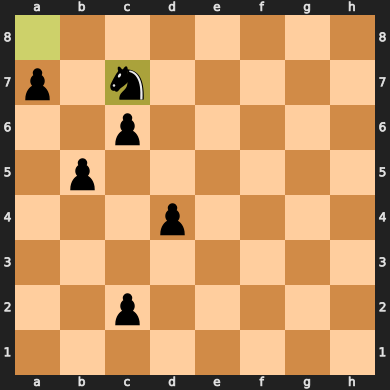

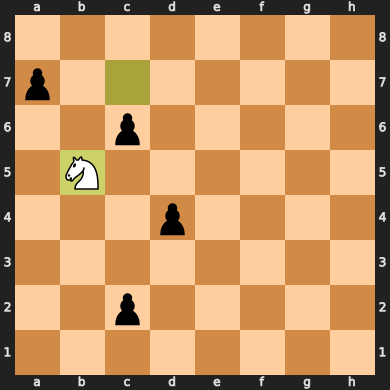

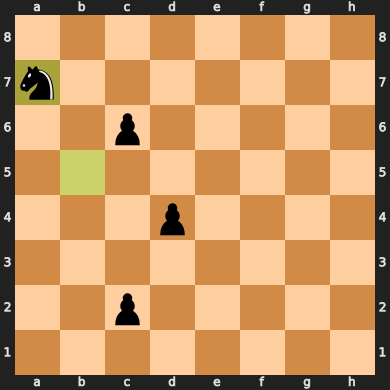

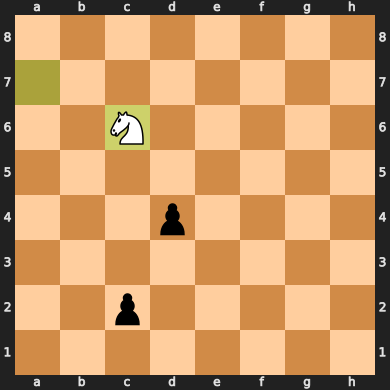

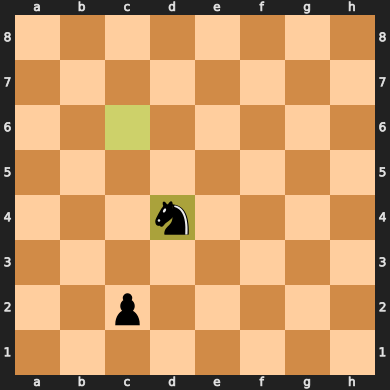

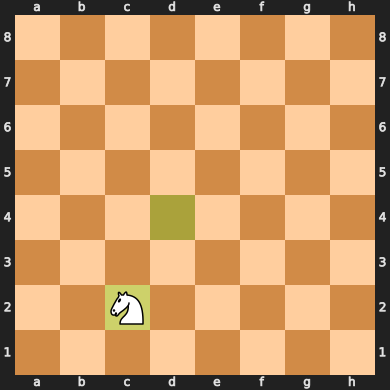

In [62]:
show_solution(Solution)